<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_PPG_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an PPG DNN by using labeled PPG data from Afib_Data_Clean notebook;
The loaded data is 30s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [1]:
from IPython.display import display, SVG
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import pydot
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
print(tf.__version__)

2.1.0


In [0]:
#run this cell to log device placement info
tf.debugging.set_log_device_placement(True)

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13334971996797983278
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6748427987139103617
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:02:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1134125693795343720
physical_device_desc: "device: 1, name: Quadro RTX 4000, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 512349813879331673
physical_device_desc: "device: 2, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 6599774044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8931598856622769431
phys

#3.Data Pipeline

## 3.1 Input Data

In [0]:
#load signal
with open('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib_ECG data/filtered_PPG_signals_p01.pkl', "rb") as fp:
  raw_signals = pickle.load(fp)

In [5]:
#create the right dim
raw_signals = np.array(raw_signals)
print('signals dim before resize',raw_signals.shape)
raw_signals = np.expand_dims(raw_signals, axis=2)
print('signals dim:', raw_signals.shape)

signals dim before resize (184856, 3750)
signals dim: (184856, 3750, 1)


In [6]:
#load label
df = pd.read_csv('C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib_ECG data/ECG_Afib_labels_p01_t05.csv',sep=',', header=None)
raw_labels = df.to_numpy()
print('labels dim',raw_labels.shape)

labels dim (184856, 1)


In [0]:
###ratio value is between 0 and 1
def slice_dataset(dataset,labels,train_ratio,seed = 30):   #make sure seed is set to a same number for repeatable results
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  train_size = int(train_ratio * DATASET_SIZE)
  val_size = DATASET_SIZE - train_size
  
  np.random.seed(seed=seed)
  np.random.shuffle(dataset)
  train_dataset = dataset[:train_size,:,:]
  val_dataset = dataset[-val_size:,:,:]

  np.random.seed(seed=seed)
  np.random.shuffle(labels)
  train_labels = labels[:train_size,:]
  val_labels = labels[-val_size:,:]

  return train_dataset,val_dataset,train_labels, val_labels

In [8]:
train_dataset, test_dataset, train_labels, test_labels  = slice_dataset(raw_signals,raw_labels,0.95)
print("train_dataset dim", train_dataset.shape)
print("train_labels dim", train_labels.shape)
print("test_dataset dim", test_dataset.shape)
print("test_labels dim", test_labels.shape)

train_dataset dim (175613, 3750, 1)
train_labels dim (175613, 1)
test_dataset dim (9243, 3750, 1)
test_labels dim (9243, 1)


In [9]:
train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(train_dataset,train_labels,0.9)
print("train_dataset dim", train_dataset.shape)
print("train_labels dim", train_labels.shape)
print("val_dataset dim", val_dataset.shape)
print("val_labels dim", val_labels.shape)

train_dataset dim (158051, 3750, 1)
train_labels dim (158051, 1)
val_dataset dim (17562, 3750, 1)
val_labels dim (17562, 1)


In [10]:
#check unique labels in train dataset
unique, count = np.unique(train_labels,return_counts=True)
print('There are', count[0], 'No Afib records in training dataset')
print('There are', count[1], 'Afib records in training dataset')

There are 117456 No Afib records in training dataset
There are 40595 Afib records in training dataset


In [11]:
#check unique labels in train dataset
unique, count = np.unique(val_labels,return_counts=True)
print('There are', count[0], 'No Afib records in validation dataset')
print('There are', count[1], 'Afib records in validation dataset')

There are 13141 No Afib records in validation dataset
There are 4421 Afib records in validation dataset


In [12]:
#check unique labels in test dataset
unique, count = np.unique(test_labels,return_counts=True)
print('There are', count[0], 'No Afib records in test dataset')
print('There are', count[1], 'Afib records in test dataset')

There are 6855 No Afib records in test dataset
There are 2388 Afib records in test dataset


## 3.2 Extract, Transform and Load data

###3.2.1 Parallelize Extraction

In [13]:
#use interleave if more than one file are used
train = tf.data.Dataset.from_tensor_slices((train_dataset,train_labels)) 

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [14]:
validation = tf.data.Dataset.from_tensor_slices((val_dataset,val_labels))

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


### 3.2.2 Parallelize Transformation


In [0]:
#don't need to run this cell, just as a placeholder
cores = multiprocessing.cpu_count()
print(cores)
#dataset = dataset.map(function, num_parallel_calls = cores)

12


### 3.2.3 Parallelize Loading

In [15]:
batch_size = 64
train_dataset = train.cache()
train_dataset = train_dataset.shuffle(len(list(train))).repeat().batch(batch_size,drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

Executing op AnonymousMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replic

#4. Train Model

##4.1 Build the ResNet

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_Points, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_Points, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path 
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_Points, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_Points, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv1D(F1, 1, strides = s, name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 2, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv1D(filters = F3, kernel_size = 1, strides = s, padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 2, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def ResNet50(input_shape=(3750, 1), classes=1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding1D(3)(X_input)

    # Stage 1
    X = Conv1D(64, 7, strides=2, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling1D(2, name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


##4.2 Define Callbacks

###4.2.1 Learning Rate Scheduler

In [0]:
def decay(epoch):
  if epoch < 30:
    return 1e-3
  elif epoch >= 30 and epoch < 70:
    return 1e-4
  else:
    return 1e-5

In [0]:
#callback: schedule a learning rate incline iteration
lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)

###4.2.2 Tensorboard

In [0]:
#callback: tensorboard
log_dir=r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data\logs\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S") +"resnet"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

###4.2.3 Confusion Matrix

In [0]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # EXERCISE: Use plt.savefig to save the plot to a PNG in memory.
    # YOUR CODE HERE
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # EXERCISE: Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # EXERCISE: Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image,0)
    
    return image

In [0]:
#https://axbihaqixpqbrrxincyxja.coursera-apps.org/notebooks/week3/TF_Serving_Week_3_Exercise_Question.ipynb

class_names = ['NO Afib','Afib']

def plot_confusion_matrix(cm, class_names, normalize=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.ylim(bottom=1.5,top = -0.5)
    
    if normalize:
      cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], 
               horizontalalignment="center", 
               verticalalignment='center', 
               color="white" if cm[i, j] > threshold else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [0]:
def log_confusion_matrix(epoch, logs):
    
    # EXERCISE: Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test_dataset)
    
    test_pred = np.where(test_pred_raw > 0.5, 1, 0)
    
    # EXERCISE: Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names, normalize = True)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [25]:
#callback: confusion matrix
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0


###4.2.4 Check Point

In [0]:
#callback: checkpoint
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data\models\resnet-p01-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## 4.3 Start Training

In [27]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) ##to overwrite NCCL cross device communication as this is running in Windows
with strategy.scope():

  model = ResNet50(input_shape=(3750,1),classes=1)

  model.compile(optimizer=tf.keras.optimizers.Adam(), 
                loss=tf.keras.losses.binary_crossentropy, 
                metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Executing op StatelessRandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job

In [28]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3750, 1)]    0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 3756, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 1875, 64)     512         zero_padding1d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 1875, 64)     256         conv1[0][0]                      
___________________________________________________________________________________________

In [29]:
%%capture
tf.keras.backend.clear_session()
callbacks_list = [lr_schedule, tensorboard_callback, cm_callback, checkpoint]
#start training
model.fit(train_dataset,
          epochs=100,
          steps_per_epoch = len(list(train))/batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps = len(list(validation))/batch_size,
          callbacks=callbacks_list
          )

INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 214 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


KeyboardInterrupt: ignored

## 4.4 Save Model for future evaluation

In [0]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model.save('Deep_PPG_ResNet_041320.h5')
print("Save model to disk")

Save model to disk


# 5. Model Evaluation

## 5.1 Load saved model

In [34]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data\models")
model = tf.keras.models.load_model('resnet_-43-0.0009.hdf5')

Executing op StatelessRandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0

## 5.2 Confusion Matrix

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_2102455 in device /job:localhost/replica:0/tas

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


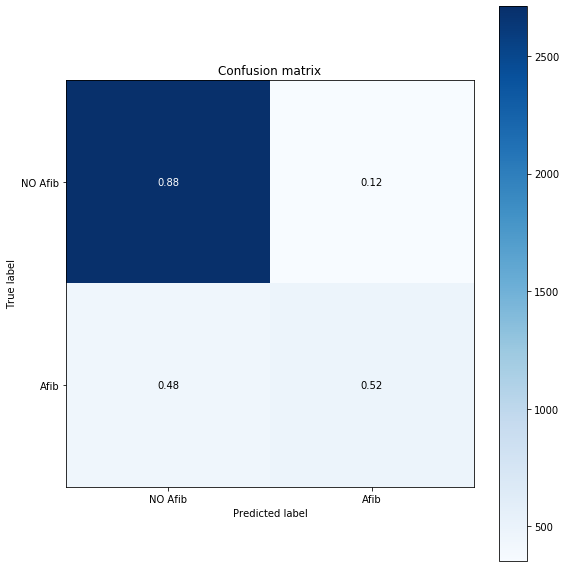

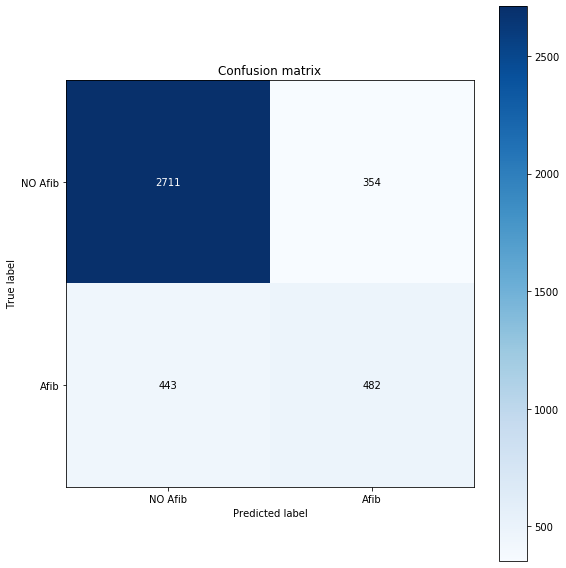

In [36]:
threshold = 0.5
test_pred_raw = model.predict(test_dataset)
test_pred = np.where(test_pred_raw > threshold, 1, 0)
# EXERCISE: Calculate the confusion matrix using sklearn.metrics
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
figure_norm = plot_confusion_matrix(cm, class_names=class_names, normalize=True)
figure_norm.show()
figure = plot_confusion_matrix(cm, class_names=class_names, normalize=False)
figure.show()

## 5.3 F-1 Score

In [0]:
report = sklearn.metrics.classification_report(test_labels, test_pred)

In [38]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3065
           1       0.58      0.52      0.55       925

    accuracy                           0.80      3990
   macro avg       0.72      0.70      0.71      3990
weighted avg       0.79      0.80      0.80      3990



## 5.4 AUC

In [0]:
score = sklearn.metrics.roc_auc_score(test_labels, test_pred)

In [40]:
print(score)

0.7027917640315683


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


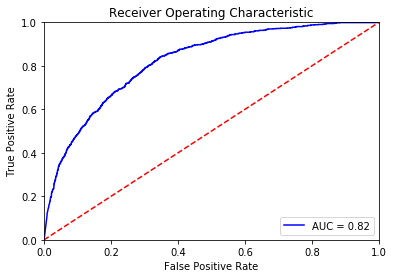

In [44]:
import sklearn.metrics as metrics
probs = model.predict(test_dataset)
preds = probs[:,]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()